**1. Setup and Data Loading**

In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import plotly.express as px

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/Data8/Data8.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

df_dask = dd.read_csv('/content/Data8.csv')
df = df_dask.compute()



Mounted at /content/drive


In [3]:
df['Start_Time'] = dd.to_datetime(df['Start_Time'], errors='coerce')
df['Year'] = df['Start_Time'].dt.year
df['Hour'] = df['Start_Time'].dt.hour
df['Weekday'] = df['Start_Time'].dt.weekday
df['Month'] = df['Start_Time'].dt.month

In [4]:
df= df[df['Year'] == 2022]
cols = ['Severity', 'Hour', 'Weekday','Month', 'Start_Lat', 'Start_Lng',
        'Temperature(F)', 'Humidity(%)', 'Visibility(mi)',
        'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition',
        'Bump', 'Crossing', 'Junction', 'Traffic_Signal','Stop','Station','Amenity',
        'Sunrise_Sunset','State']


In [5]:
df['Sunrise_Sunset'] = df['Sunrise_Sunset'].map({'Day': 0, 'Night': 1})

In [6]:
cols = [ 'Temperature(F)', 'Pressure(in)']

df[cols] = df[cols].fillna(df[cols].mean())

In [7]:
cols = ['Precipitation(in)',
    'Wind_Speed(mph)', 'Visibility(mi)', 'Humidity(%)']

df[cols] = df[cols].fillna(df[cols].mean())

In [8]:
df=df.dropna()

<ipython-input-9-543ef5769e3c>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_weather.index, x=top_weather.values, palette='coolwarm')


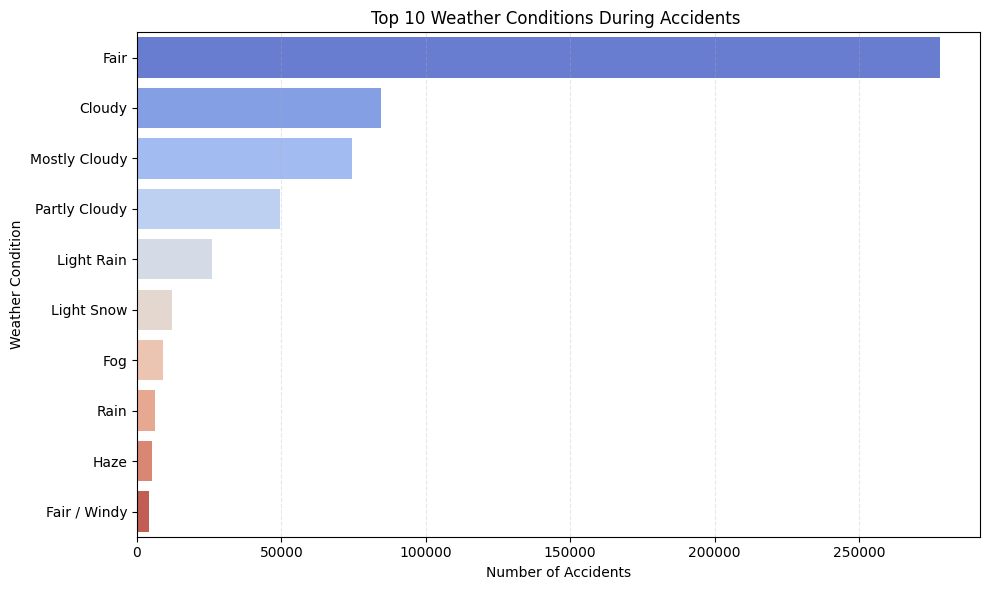

In [9]:
def simplify_weather_condition(condition):
    condition = condition.lower()

    if 'tornado' in condition:
        return 'Extreme'
    elif 'thunder' in condition or 't-storm' in condition or 'hail' in condition:
        return 'Thunderstorm'
    elif ('snow' in condition or 'sleet' in condition or
          'wintry mix' in condition or 'ice pellets' in condition or
          'snow grains' in condition or 'blowing snow' in condition):
        return 'Snow'
    elif 'freezing rain' in condition or 'freezing drizzle' in condition:
        return 'Freezing Rain'
    elif 'rain' in condition or 'shower' in condition:
        return 'Rain'
    elif 'drizzle' in condition:
        return 'Drizzle'
    elif ('fog' in condition or 'mist' in condition or
          'haze' in condition or 'partial fog' in condition or
          'shallow fog' in condition or 'patches of fog' in condition):
        return 'Fog/Haze'
    elif ('dust' in condition or 'sand' in condition or
          'smoke' in condition):
        return 'Dust/Smoke'
    elif ('wind' in condition or 'windy' in condition or
          'squall' in condition):
        return 'Windy'
    elif 'clear' in condition or 'fair' in condition:
        return 'Clear'
    elif 'cloud' in condition or 'overcast' in condition:
        return 'Cloudy'
    elif 'n/a' in condition:
        return 'Unknown'
    else:
        return 'Other'



# Application
df['Weather_Condition_Simplified'] = df['Weather_Condition'].apply(simplify_weather_condition)
def plot_weather_conditions(df, top_n=10):
    top_weather = df['Weather_Condition'].value_counts().nlargest(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(y=top_weather.index, x=top_weather.values, palette='coolwarm')
    plt.title(f'Top {top_n} Weather Conditions During Accidents ')
    plt.xlabel('Number of Accidents')
    plt.ylabel('Weather Condition')
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
plot_weather_conditions(df, top_n=10)


In [10]:
df = df.dropna()

**2. Feature Selection for Clustering**

In [11]:
df_sample = df.sample(n=10000, random_state=42)

In [12]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
features = [
    'Severity', 'Hour', 'Weekday','Month', 'Start_Lat', 'Start_Lng',
    'Temperature(F)', 'Humidity(%)', 'Visibility(mi)',
    'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition_Simplified',
    'Bump', 'Crossing', 'Junction', 'Traffic_Signal','Stop','Station','Amenity',
    'Sunrise_Sunset'
]


X = df_sample[features]
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), [col for col in features if df_sample[col].dtype != 'object']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Weather_Condition_Simplified'])
])
X_scaled = preprocessor.fit_transform(X)

**3. Determine Optimal Number of Clusters (Elbow Method)**

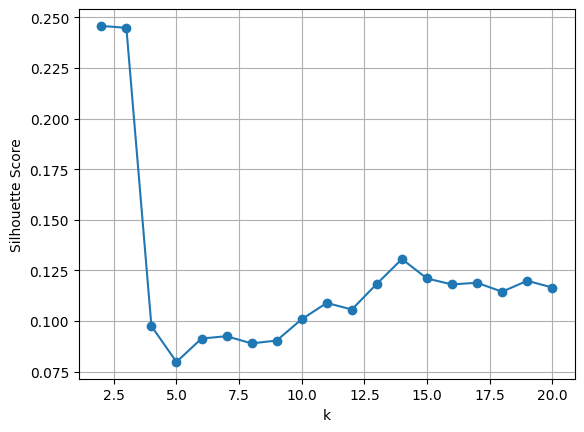

best k = 2


In [13]:
scores = []
k_range = range(2, 21)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append(score)

plt.plot(k_range, scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

best_k = k_range[np.argmax(scores)]
print(f"best k = {best_k}")

**4. Apply KMeans with Optimal Cluster Number**

In [14]:
optimal_k = best_k  # Replace with value from elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_sample['Cluster'] = kmeans.fit_predict(X_scaled)

**5. Cluster Summary Function**

In [15]:
def summarize_clusters(df, cluster_col='Cluster'):
    results = []
    for cluster in sorted(df[cluster_col].unique()):
        group = df[df[cluster_col] == cluster]
        severity_dist = group['Severity'].value_counts(normalize=True).sort_index()
        row = {
            'Cluster': cluster,
            'Nb_accidents': len(group),
            'Lat_moy': round(group['Start_Lat'].mean(), 2),
            'Lng_moy': round(group['Start_Lng'].mean(), 2),
            'Peak_Hour': group['Hour'].mode()[0],
            'Severity_1(%)': round(severity_dist.get(1, 0)*100, 1),
            'Severity_2(%)': round(severity_dist.get(2, 0)*100, 1),
            'Severity_3(%)': round(severity_dist.get(3, 0)*100, 1),
            'Severity_4(%)': round(severity_dist.get(4, 0)*100, 1),
            'Visibility_Avg': round(group['Visibility(mi)'].mean(), 2),
            'Night_%': round((group['Sunrise_Sunset'] == 1).mean()*100, 1),
            'Top_Weather': group['Weather_Condition_Simplified'].value_counts().idxmax() if 'Weather_Condition' in group else None

        }
        results.append(row)
    return pd.DataFrame(results)
summary_df = summarize_clusters(df_sample, cluster_col='Cluster')
display(summary_df)

,Cluster,Nb_accidents,Lat_moy,Lng_moy,Peak_Hour,Severity_1(%),Severity_2(%),Severity_3(%),Severity_4(%),Visibility_Avg,Night_%,Top_Weather
0,0,476,38.25,-88.08,15.0,0.0,0.0,34.7,65.3,8.96,35.9,Cloudy
1,1,9524,35.92,-95.06,16.0,0.9,99.1,0.0,0.0,9.07,35.4,Clear


**6. Visualization on Map**

In [16]:
fig = px.scatter_mapbox(
    df_sample, lat="Start_Lat", lon="Start_Lng", color="Cluster", zoom=2,
    mapbox_style="carto-positron", opacity=0.6, title="Clusters on Map")
fig.show()

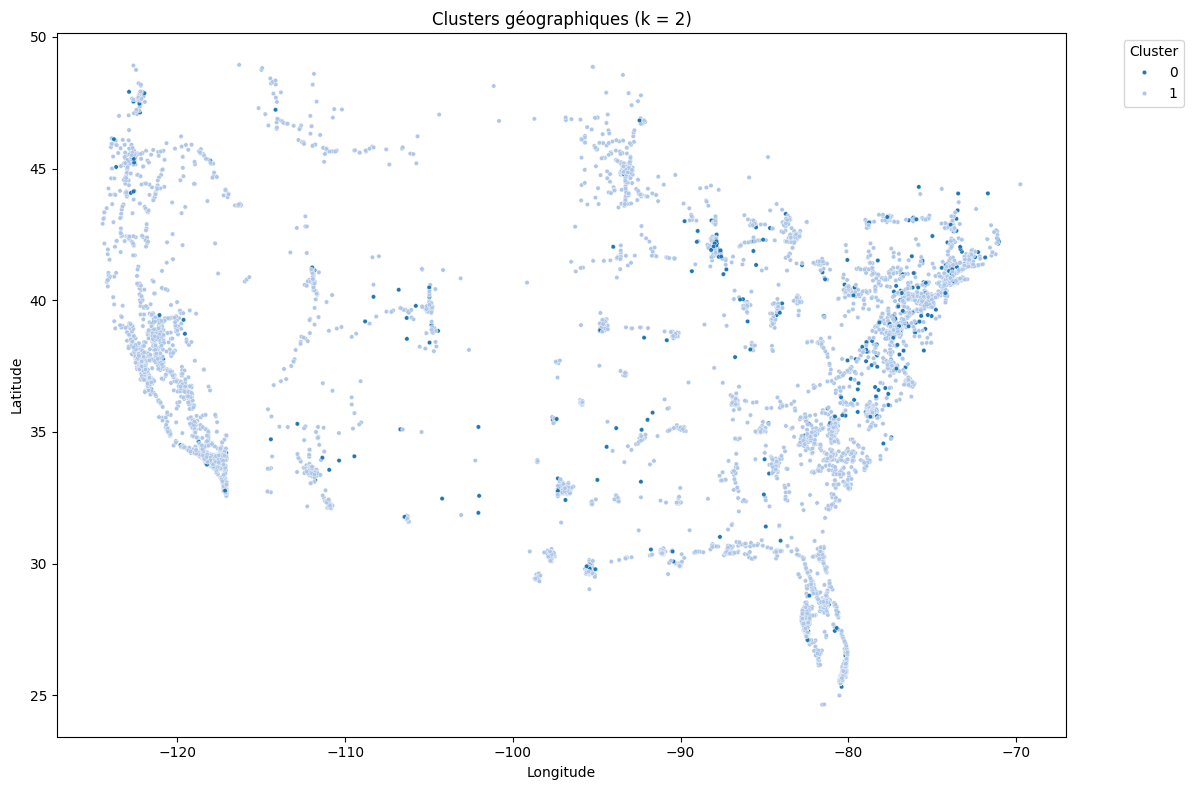

In [17]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_sample, x='Start_Lng', y='Start_Lat', hue='Cluster', palette='tab20', s=10)
plt.title(f"Clusters géographiques (k = {best_k})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [18]:
state = 'CA'
df_state = df[df['State'] == state]
df_state_sample = df_state.sample(n=20000, random_state=42)

# features =
[                                                        
   'Severity', 'Hour', 'Weekday','Month', 'Start_Lat', 'Start_Lng',
        'Temperature(F)', 'Humidity(%)', 'Visibility(mi)',
        'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition_Simplified',
        'Bump', 'Crossing', 'Junction', 'Traffic_Signal','Stop','Station','Amenity',
        'Sunrise_Sunset'
        ]

In [19]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

features = ['Severity', 'Hour', 'Start_Lat', 'Start_Lng',
        'Temperature(F)', 'Humidity(%)', 'Visibility(mi)',
        'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition_Simplified',
        'Bump', 'Crossing', 'Junction', 'Traffic_Signal','Stop','Station','Amenity',
        'Sunrise_Sunset']

df_cluster = df_state_sample[features].copy()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), [col for col in features if df_cluster[col].dtype != 'object']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Weather_Condition_Simplified'])
])


100%|██████████| 18/18 [01:34<00:00,  5.22s/it]


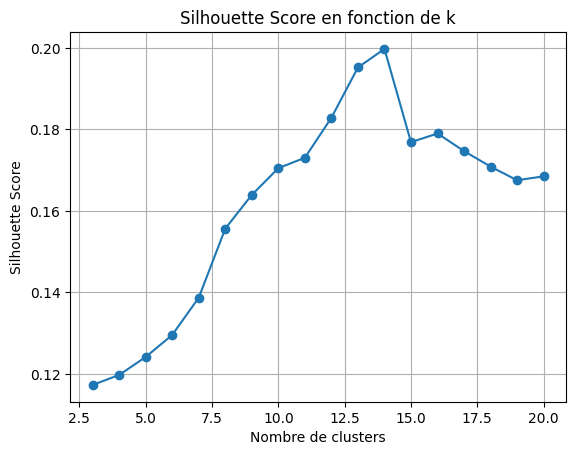

✅ Meilleur nombre de clusters selon Silhouette Score : 14


In [20]:
# 3. Transformation des données
X_prepared = preprocessor.fit_transform(df_cluster)

# 4. Recherche du meilleur k avec Silhouette
from tqdm import tqdm
silhouette_scores = []
range_n = range(3, 21)

for k in tqdm(range_n):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_prepared)
    score = silhouette_score(X_prepared, labels)
    silhouette_scores.append(score)

# 5. Trouver le meilleur k
import matplotlib.pyplot as plt
plt.plot(range_n, silhouette_scores, marker='o')
plt.title("Silhouette Score en fonction de k")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

best_k = range_n[np.argmax(silhouette_scores)]
print(f" Meilleur nombre de clusters selon Silhouette Score : {best_k}")

# 6. Application finale du clustering
final_model = KMeans(n_clusters=best_k, random_state=42)
df_state_sample['Cluster_behavior'] = final_model.fit_predict(X_prepared)

In [21]:
summarize_clusters(df_state_sample, cluster_col='Cluster_behavior')


,Cluster,Nb_accidents,Lat_moy,Lng_moy,Peak_Hour,Severity_1(%),Severity_2(%),Severity_3(%),Severity_4(%),Visibility_Avg,Night_%,Top_Weather
0,0,3270,34.06,-118.01,16.0,0.0,100.0,0.0,0.0,9.45,84.3,Clear
1,1,5033,34.03,-117.99,16.0,0.0,100.0,0.0,0.0,9.64,4.2,Clear
2,2,2891,38.20,-121.65,16.0,1.2,98.8,0.0,0.0,9.56,64.0,Clear
3,3,170,35.78,-119.88,17.0,0.0,98.2,0.0,1.8,9.31,29.4,Clear
4,4,1593,35.50,-119.45,16.0,1.5,98.5,0.0,0.0,9.31,38.7,Clear
5,5,1404,36.08,-119.68,15.0,0.2,99.8,0.0,0.0,2.91,41.5,Fog/Haze
6,6,629,36.25,-119.99,15.0,0.5,99.0,0.5,0.0,9.30,37.4,Clear
7,7,15,36.58,-120.94,13.0,6.7,93.3,0.0,0.0,9.93,33.3,Clear
8,8,764,36.22,-120.00,16.0,0.9,99.0,0.1,0.0,9.20,37.0,Clear
9,9,221,35.71,-119.54,15.0,0.0,0.0,38.9,61.1,9.34,28.5,Clear


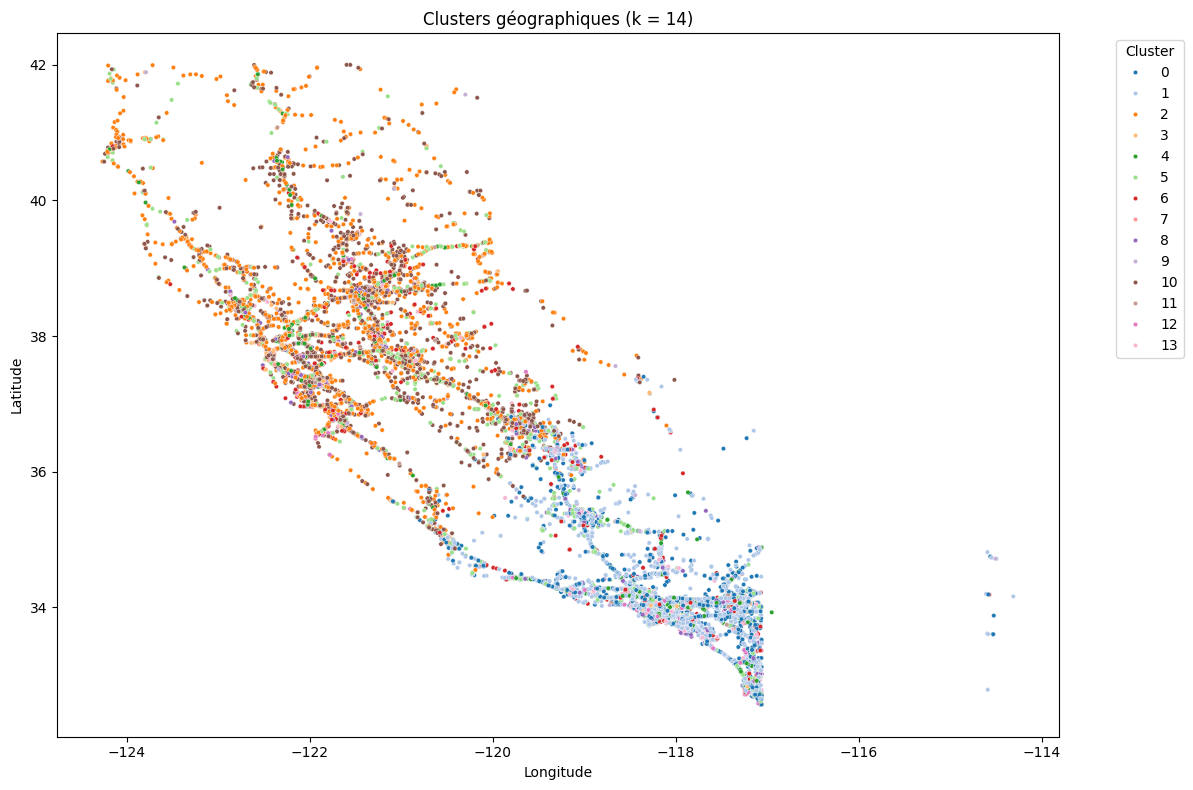

In [22]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_state_sample, x='Start_Lng', y='Start_Lat', hue='Cluster_behavior', palette='tab20', s=10)
plt.title(f"Clusters géographiques (k = {best_k})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [23]:
def summarize_clusters(df, cluster_col='Cluster'):
    results = []
    for cluster in sorted(df[cluster_col].unique()):
        group = df[df[cluster_col] == cluster]
        severity_dist = group['Severity'].value_counts(normalize=True).sort_index()
        row = {
            'Cluster': cluster,
            'Nb_accidents': len(group),
            'Lat_moy': round(group['Start_Lat'].mean(), 2),
            'Lng_moy': round(group['Start_Lng'].mean(), 2),
            'Peak_Hour': group['Hour'].mode()[0],
            'Severity_1(%)': round(severity_dist.get(1, 0)*100, 1),
            'Severity_2(%)': round(severity_dist.get(2, 0)*100, 1),
            'Severity_3(%)': round(severity_dist.get(3, 0)*100, 1),
            'Severity_4(%)': round(severity_dist.get(4, 0)*100, 1),
            'Visibility_Avg': round(group['Visibility(mi)'].mean(), 2),
            'Night_%': round((group['Sunrise_Sunset'] == 1).mean()*100, 1),
            'Top_Weather': group['Weather_Condition_Simplified'].value_counts().idxmax() if 'Weather_Condition' in group else None

        }
        results.append(row)
    return pd.DataFrame(results)

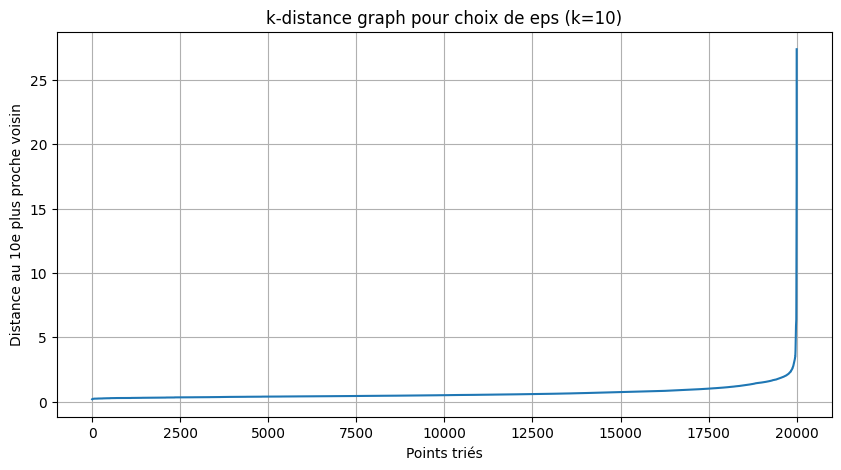

In [24]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Sélection des features
features = ['Severity', 'Hour',
        'Temperature(F)', 'Humidity(%)', 'Visibility(mi)',
        'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition_Simplified',
        'Sunrise_Sunset']

df_cluster = df_state_sample[features].copy()

# 2. Prétraitement
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), [col for col in features if df_cluster[col].dtype != 'object']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Weather_Condition_Simplified'])
])

X_prepared = preprocessor.fit_transform(df_cluster)

# 3. Recherche des meilleurs paramètres pour DBSCAN
from sklearn.neighbors import NearestNeighbors

# Aide visuelle pour déterminer eps
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_prepared)
distances, indices = neighbors_fit.kneighbors(X_prepared)
distances = np.sort(distances[:, 9])  # 9 = n_neighbors - 1

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title("k-distance graph pour choix de eps (k=10)")
plt.xlabel("Points triés")
plt.ylabel("Distance au 10e plus proche voisin")
plt.grid(True)
plt.show()


✅ Silhouette Score (sans bruit) : 0.2143


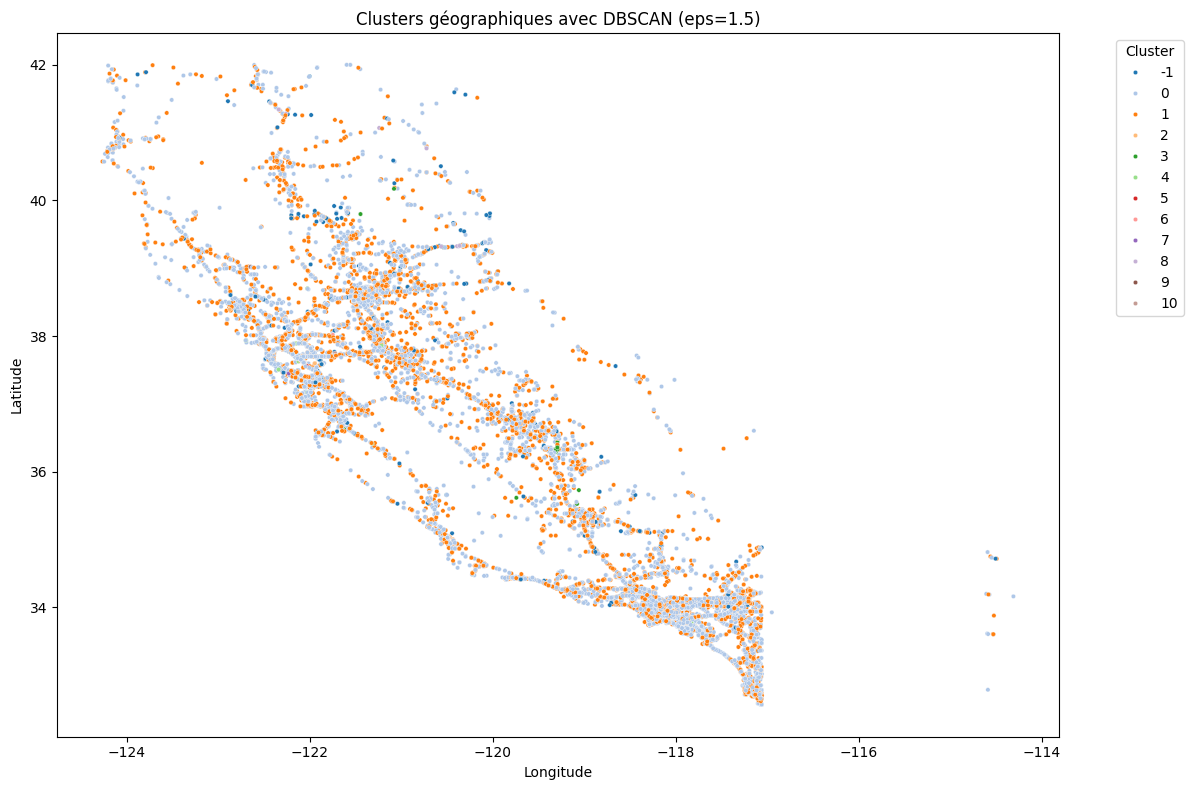

,Cluster,Nb_accidents,Lat_moy,Lng_moy,Peak_Hour,Severity_1(%),Severity_2(%),Severity_3(%),Severity_4(%),Visibility_Avg,Night_%,Top_Weather
0,-1,488,36.81,-120.20,16.0,12.9,68.2,5.9,12.9,7.35,44.7,Rain
1,0,12193,35.61,-119.43,16.0,0.0,100.0,0.0,0.0,9.19,0.0,Clear
2,1,7106,35.78,-119.52,16.0,0.0,100.0,0.0,0.0,8.93,100.0,Clear
3,2,22,38.05,-121.71,16.0,100.0,0.0,0.0,0.0,9.95,100.0,Clear
4,3,64,36.19,-119.72,16.0,0.0,0.0,0.0,100.0,9.80,0.0,Clear
5,4,62,35.46,-119.53,6.0,0.0,0.0,100.0,0.0,9.89,0.0,Clear
6,5,10,37.70,-122.05,16.0,100.0,0.0,0.0,0.0,10.00,100.0,Cloudy
7,6,10,37.57,-121.48,15.0,100.0,0.0,0.0,0.0,10.00,0.0,Cloudy
8,7,11,37.88,-121.60,6.0,100.0,0.0,0.0,0.0,9.82,0.0,Clear
9,8,13,39.51,-120.69,7.0,0.0,100.0,0.0,0.0,1.02,0.0,Snow


In [25]:
# 4. Application de DBSCAN
eps_val = 1.5  # À ajuster selon la courbe
dbscan_model = DBSCAN(eps=eps_val, min_samples=10)
labels = dbscan_model.fit_predict(X_prepared)

df_state_sample['Cluster_behavior'] = labels

# 5. Silhouette score (en ignorant les -1)
mask = labels != -1
if len(set(labels[mask])) > 1:
    score = silhouette_score(X_prepared[mask], labels[mask])
    print(f" Silhouette Score (sans bruit) : {score:.4f}")
else:
    print(" Trop de bruit ou un seul cluster détecté, Silhouette non applicable.")

# 6. Visualisation géographique
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_state_sample, x='Start_Lng', y='Start_Lat', hue='Cluster_behavior', palette='tab20', s=10)
plt.title(f"Clusters géographiques avec DBSCAN (eps={eps_val})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 7. Résumé par cluster
summarize_clusters(df_state_sample, cluster_col='Cluster_behavior')


100%|██████████| 18/18 [12:27<00:00, 41.52s/it]


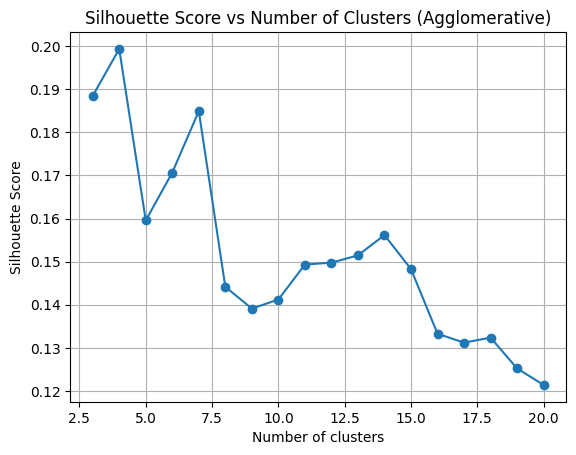

✅ Best number of clusters according to Silhouette Score: 4


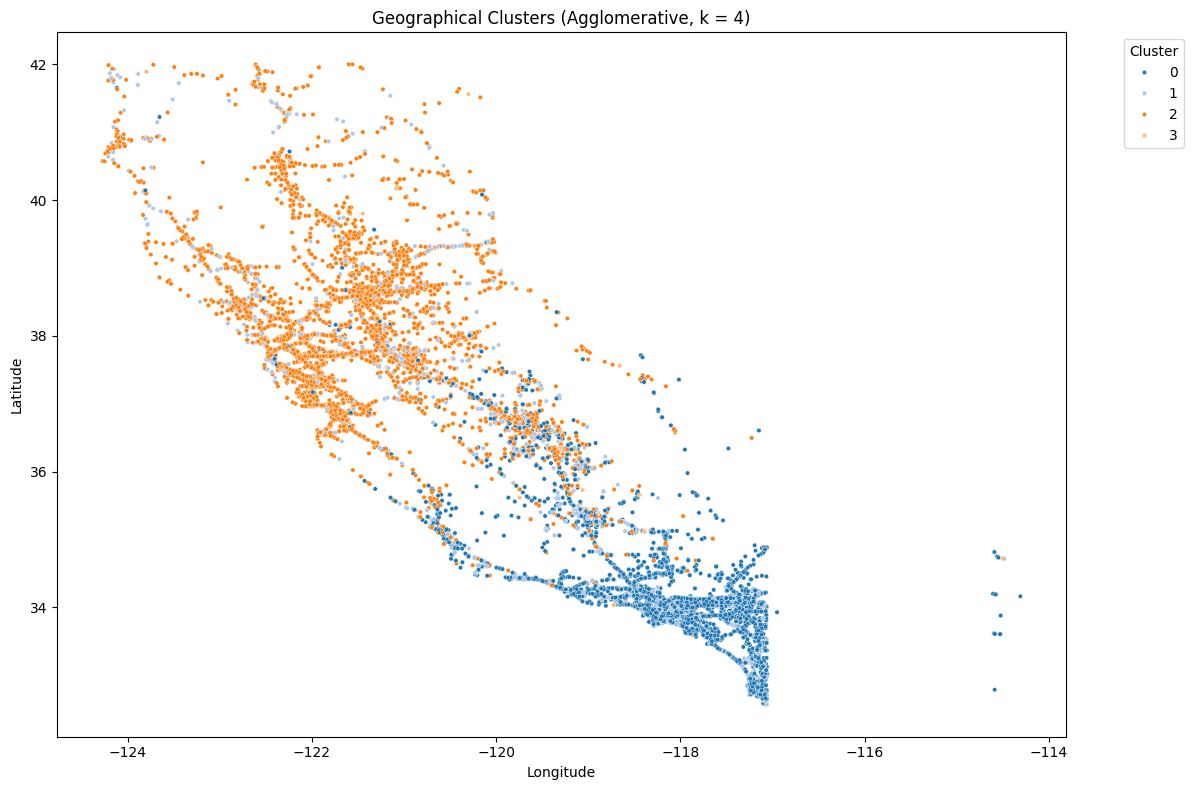

In [26]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# 1. Feature selection
features = ['Severity', 'Hour', 'Start_Lat', 'Start_Lng',
        'Temperature(F)', 'Humidity(%)', 'Visibility(mi)',
        'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition_Simplified',
        'Sunrise_Sunset']

df_cluster = df_state_sample[features].copy()

# 2. Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), [col for col in features if df_cluster[col].dtype != 'object']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Weather_Condition_Simplified'])
])

# 3. Data transformation
X_prepared = preprocessor.fit_transform(df_cluster)

# 4. Search for best number of clusters using Silhouette Score
silhouette_scores = []
range_n = range(3, 21)

for k in tqdm(range_n):
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(X_prepared.toarray() if hasattr(X_prepared, "toarray") else X_prepared)
    score = silhouette_score(X_prepared.toarray() if hasattr(X_prepared, "toarray") else X_prepared, labels)
    silhouette_scores.append(score)

# 5. Find best k
plt.plot(range_n, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters (Agglomerative)")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

best_k = range_n[np.argmax(silhouette_scores)]
print(f" Best number of clusters according to Silhouette Score: {best_k}")

# 6. Final clustering
final_model = AgglomerativeClustering(n_clusters=best_k)
df_state_sample['Cluster_behavior'] = final_model.fit_predict(X_prepared.toarray() if hasattr(X_prepared, "toarray") else X_prepared)

# 7. Summarize clusters
summarize_clusters(df_state_sample, cluster_col='Cluster_behavior')

# 8. Plot clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_state_sample, x='Start_Lng', y='Start_Lat', hue='Cluster_behavior', palette='tab20', s=10)
plt.title(f"Geographical Clusters (Agglomerative, k = {best_k})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [27]:
summarize_clusters(df_state_sample, cluster_col='Cluster_behavior')


,Cluster,Nb_accidents,Lat_moy,Lng_moy,Peak_Hour,Severity_1(%),Severity_2(%),Severity_3(%),Severity_4(%),Visibility_Avg,Night_%,Top_Weather
0,0,10128,34.10,-118.08,16.0,0.0,100.0,0.0,0.0,9.75,34.2,Clear
1,1,2637,35.79,-119.50,16.0,0.0,100.0,0.0,0.0,4.13,46.8,Fog/Haze
2,2,7006,38.01,-121.53,16.0,1.7,98.3,0.0,0.0,9.88,37.4,Clear
3,3,229,35.73,-119.55,16.0,0.0,0.0,39.7,60.3,9.36,28.4,Clear
